<a href="https://colab.research.google.com/github/BrunoTrinitario/IA2024-TP/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math as ma
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation, Input, concatenate
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.callbacks import History
from re import T

In [ ]:
def generateData(data_path):
  df=pd.read_csv(data_path)
  anios = df.iloc[:, 0].tolist()
  temperaturas = df.iloc[:, 1].tolist()
  data=df.iloc[:, 2:]
  temperaturas=np.array(temperaturas)
  data=np.array(data)
  return anios,temperaturas,data

def normData(data):
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  return data

def modelo(data):
  model = Sequential()
  model.add(LSTM(128, return_sequences= True, input_shape=(100, data.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences= True))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences= False))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation= 'linear'))
  model.compile(optimizer=optimizers.Adam(), loss='mse')
  return model

def entrenar_modelo(modelo, epocas, train_data, train_targets):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = modelo.fit(
        train_data,
        train_targets,
        epochs=epocas,
        batch_size=16,
        verbose=1,
        shuffle=False,  # No shuffle para series temporales
        callbacks=[early_stopping]
      )

    return history

def graphYVT(x,y,type):
  plt.plot(x, y, label=type, color=np.random.rand(3,), linestyle='-', linewidth=2)
  plt.title('Anio VS. Temp')
  plt.xlabel('Anio')
  plt.legend()
  plt.ylabel('Temperatura')

def generateTestData(anio, temp, trainData):
  test_mat=np.insert(trainData,0,anio,axis=1)
  test_mat=np.insert(test_mat,1,temp,axis=1)

  medias_por_anio = []
  anios_unicos = np.unique(test_mat[:, 0])
  # Iterar sobre cada año único
  for anio in anios_unicos:
    filas_anio = test_mat[test_mat[:, 0] == anio]
    promedio = np.mean(filas_anio, axis=0)
    medias_por_anio.append(promedio)

def predict_future_temperatures(model, testData, timeSize):

  predictions = []
  for i in range(testData.shape[0]-timeSize+1):
    # Predecir el siguiente valor
    current_data = testData[i:i+timeSize].reshape(1,timeSize,28)
    next_prediction = model.predict(current_data)
    predictions.append(next_prediction) #Tomamos el primer valor

  return np.array(predictions)

def promedioAnio(matriz):
    anios = matriz[:, 0]
    datos = matriz[:, 1:]
    anios_unicos = np.unique(anios)
    resultado = []
    for anio in anios_unicos:
        filas_anio = datos[anios == anio]
        promedio = filas_anio.mean(axis=0)
        resultado.append([anio] + promedio.tolist())
    resultado = np.array(resultado)
    return resultado

In [ ]:
anios,temperaturas,trainData=generateData('./trainData.csv')
generateTestData(anios,temperaturas,trainData)
trainData=normData(trainData)
trainData=np.expand_dims(trainData,axis=1)
model=modelo(trainData)
entrenar_modelo(model,80,trainData,temperaturas)


Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 216.0140
Epoch 2/80


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.8582
Epoch 3/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.7471
Epoch 4/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.7096
Epoch 5/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.6754
Epoch 6/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.0421
Epoch 7/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.7186
Epoch 8/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5538
Epoch 9/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.3946
Epoch 10/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.4634
Epoch 11/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.3775
Epoch 12/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.3288
Epoch 13/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.2191
Epoch 14/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2614
Epoch 15/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.2395
Epoch 16/80
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2

In [ ]:
aux1,testTarget,testData=generateData('./testData.csv')
testData=normData(testData)
cantYrsPredict=3
predicciones=predict_future_temperatures(model, testData, cantYrsPredict)
predicciones=predicciones.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
aux2,testY,testX=generateData('./trueTestData.csv')
testX=normData(testX)
testX=np.expand_dims(testX,axis=1)
loss=model.evaluate(testX,testY,verbose=1)
print("Loss:",loss)
rmse = np.sqrt(np.mean((predicciones - testTarget[cantYrsPredict-1:])**2))
print("Error minimo cuadrado:",rmse)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0946
Loss: 0.08138207346200943
Error minimo cuadrado: 6.64129869473713


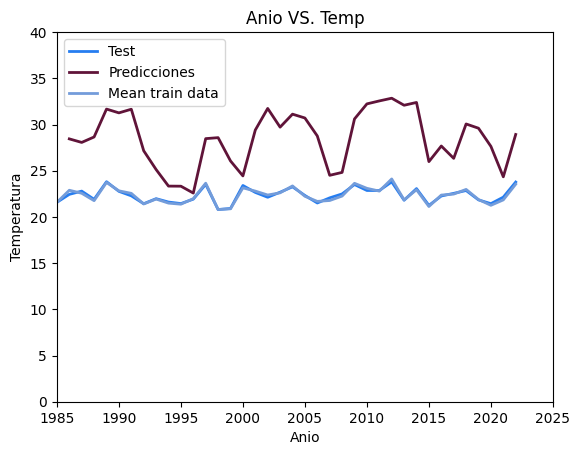

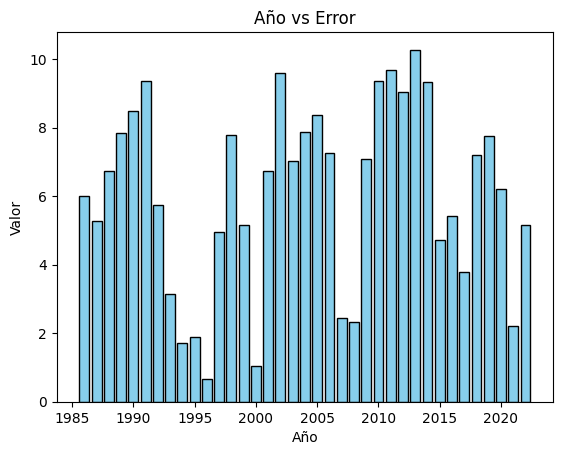

In [78]:
graphYVT(aux1,testTarget,'Test')
graphYVT(aux1[cantYrsPredict-1:],predicciones,'Predicciones')
originalData=np.column_stack((anios, temperaturas))
originalData=promedioAnio(originalData)
graphYVT(originalData[:,0],originalData[:,1],'Mean train data')
plt.xlim(1985, 2025)  # Limitar el eje X
plt.ylim(0, 40)
plt.show()

vector_dif=predicciones - testTarget[cantYrsPredict-1:]
plt.bar(aux1[cantYrsPredict-1:], vector_dif, color='skyblue', edgecolor='black')
plt.title('Año vs Error')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.show()
